**Прогноз отказа мотора на основе показаний датчиков**

**Задача:** прогноз отказа мотора на следующем цикле. Считаем, что максимальный цикл мотора - это последний цикл перед поломкой. Нужно предложить варианты использования полученной модели на практике. 

**Описание данных:**

- id -- идентификатор мотора
- cycle -- цикл работы
- p00-p20 -- показания датчиков считываемые в процессе работы
- s0, s1 -- настройки изменяемые в конце каждого цикла

Задача была мной интерпретирована как задача на анализ выживаемости или надёжности (survival analysis). То есть, буду рассчитывать, как различные факторы влияют на продолжительность работы мотора и анализировать время до наступления отказа мотора



# Импорт нужных библиотек

решение выполнялось в google colab, установим нужные пакеты и затем импорируем библиотеки

In [1]:
! pip install sklearn-pandas

In [2]:
pip install torchtuples

     |████████████████████████████████| 51kB 4.2MB/s 


In [3]:
!pip install pycox

     |████████████████████████████████| 81kB 3.6MB/s 


In [4]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

In [5]:
import torch  
import torchtuples as tt 

In [6]:
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [7]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [8]:
df_train = pd.read_csv('data.csv')

# EDA




Рассмотрим, какие типы данных у столбцов и сколько пропусков:

In [9]:
display(df_train.head()) 
df_train.info() 

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p00     16138 non-null  float64
 3   p01     16138 non-null  float64
 4   p02     16138 non-null  float64
 5   p03     16138 non-null  float64
 6   p04     16138 non-null  float64
 7   p05     16138 non-null  float64
 8   p06     16138 non-null  float64
 9   p07     16138 non-null  float64
 10  p08     16138 non-null  int64  
 11  p09     16138 non-null  int64  
 12  p10     16138 non-null  int64  
 13  p11     16138 non-null  float64
 14  p12     16138 non-null  float64
 15  p13     16138 non-null  float64
 16  p14     16138 non-null  float64
 17  p15     16138 non-null  float64
 18  p16     16138 non-null  float64
 19  p17     16138 non-null  float64
 20  p18     16138 non-null  float64
 21  p19     16138 non-null  float64
 22

вот так нагляднее видно, что пропусков в данных нет

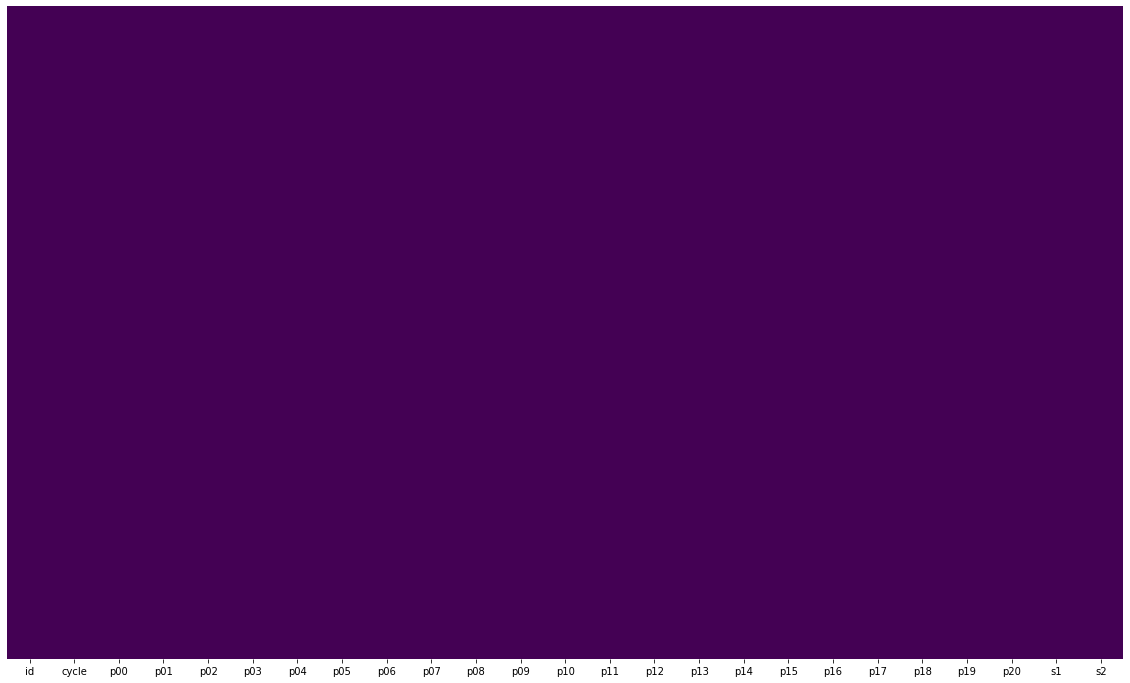

In [10]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

Пропуски отсутствуют.

Напишем функцию, которая покажет нам распределение признаков и выбросы для столбцов, у которых определены значения (по описанию датасета). 

In [21]:
def desription(col, boundaries = None):
    print('Столбец', col)
    print('Распределение признака:')
    fig, ax = plt.subplots()
    if df_train.loc[:, col].dtypes == np.dtype('O'): # Проверка на строковый тип данных
        sns.countplot(df_train.loc[:, col], ax=ax)
        plt.show()
    else:
        
        df_train.loc[:, col].hist(ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel('count')
        plt.show()
        if boundaries is not None: # Проверка на наличие выбросов по информации из датасета
            if df_train.loc[(~df_train.loc[:, col].between(boundaries[0], boundaries[1]))&
                       pd.notnull(data.loc[:, col])].shape[0] > 0:
                print('Найдены выбросы:')
                display(df_train.loc[(~df_train.loc[:, col].between(boundaries[0], boundaries[1]))&
                       pd.notnull(df_train.loc[:, col])])
                
    #print('Процент пропусков:', str(round(100 - df_train.loc[:, col].count()/df_train.shape[0]*100, 2)) + '%')
    #print()
    print('Детальное описание:')
    print(df_train.loc[:, col].describe())

Столбец cycle
Распределение признака:


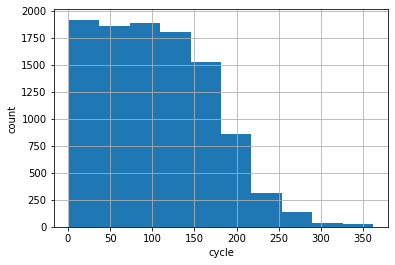

Детальное описание:
count    10328.000000
mean       104.867932
std         65.738063
min          1.000000
25%         50.000000
50%        101.000000
75%        152.000000
max        362.000000
Name: cycle, dtype: float64
Столбец p00
Распределение признака:


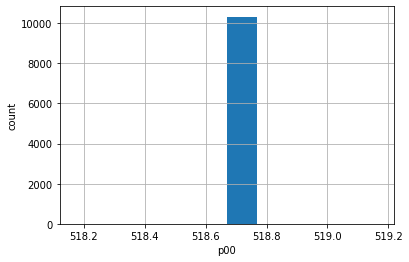

Детальное описание:
count    1.032800e+04
mean     5.186700e+02
std      5.627771e-11
min      5.186700e+02
25%      5.186700e+02
50%      5.186700e+02
75%      5.186700e+02
max      5.186700e+02
Name: p00, dtype: float64
Столбец p01
Распределение признака:


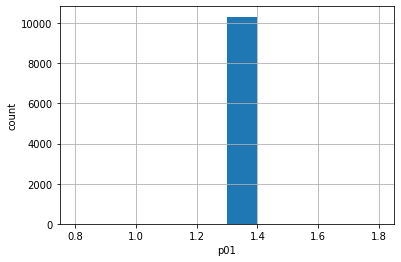

Детальное описание:
count    1.032800e+04
mean     1.300000e+00
std      2.054012e-13
min      1.300000e+00
25%      1.300000e+00
50%      1.300000e+00
75%      1.300000e+00
max      1.300000e+00
Name: p01, dtype: float64
Столбец p02
Распределение признака:


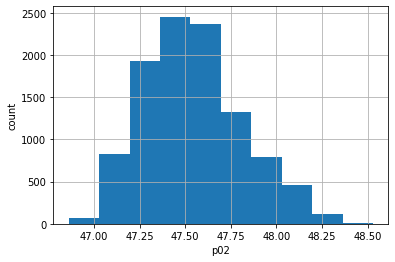

Детальное описание:
count    10328.000000
mean        47.543143
std          0.268190
min         46.860000
25%         47.350000
50%         47.520000
75%         47.710000
max         48.530000
Name: p02, dtype: float64
Столбец p03
Распределение признака:


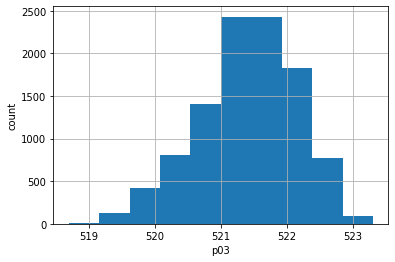

Детальное описание:
count    10328.000000
mean       521.406030
std          0.741286
min        518.690000
25%        520.950000
50%        521.460000
75%        521.950000
max        523.310000
Name: p03, dtype: float64
Столбец p04
Распределение признака:


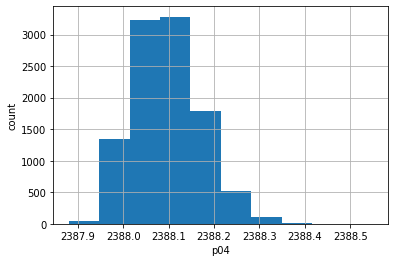

Детальное описание:
count    10328.000000
mean      2388.097003
std          0.072786
min       2387.880000
25%       2388.040000
50%       2388.090000
75%       2388.140000
max       2388.550000
Name: p04, dtype: float64
Столбец p05
Распределение признака:


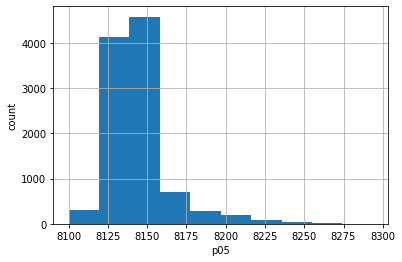

Детальное описание:
count    10328.000000
mean      8143.709993
std         19.540530
min       8099.940000
25%       8132.570000
50%       8140.570000
75%       8148.722500
max       8293.720000
Name: p05, dtype: float64
Столбец p06
Распределение признака:


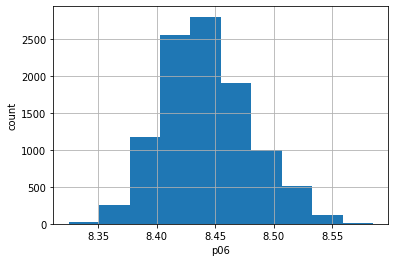

Детальное описание:
count    10328.000000
mean         8.442340
std          0.037684
min          8.324900
25%          8.415000
50%          8.439300
75%          8.465700
max          8.584800
Name: p06, dtype: float64
Столбец p07
Распределение признака:


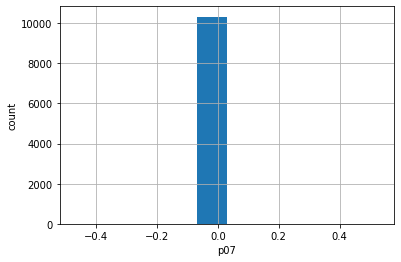

Детальное описание:
count    1.032800e+04
mean     3.000000e-02
std      3.875560e-15
min      3.000000e-02
25%      3.000000e-02
50%      3.000000e-02
75%      3.000000e-02
max      3.000000e-02
Name: p07, dtype: float64
Столбец p08
Распределение признака:


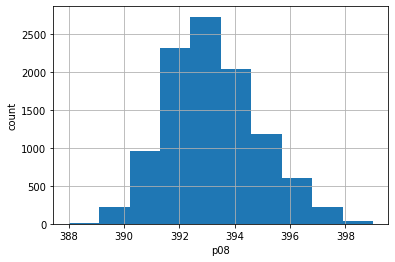

Детальное описание:
count    10328.000000
mean       393.230442
std          1.541949
min        388.000000
25%        392.000000
50%        393.000000
75%        394.000000
max        399.000000
Name: p08, dtype: float64
Столбец p09
Распределение признака:


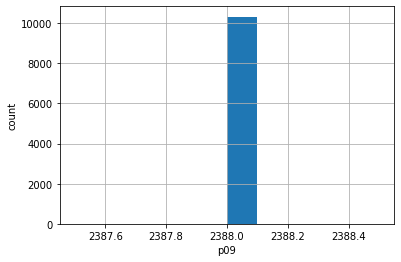

Детальное описание:
count    10328.0
mean      2388.0
std          0.0
min       2388.0
25%       2388.0
50%       2388.0
75%       2388.0
max       2388.0
Name: p09, dtype: float64
Столбец p10
Распределение признака:


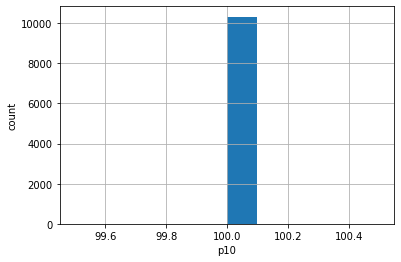

Детальное описание:
count    10328.0
mean       100.0
std          0.0
min        100.0
25%        100.0
50%        100.0
75%        100.0
max        100.0
Name: p10, dtype: float64
Столбец p11
Распределение признака:


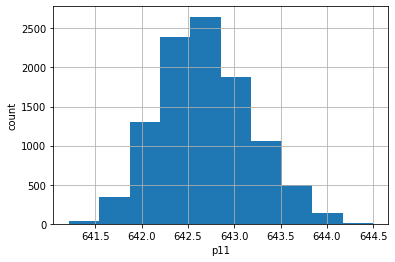

Детальное описание:
count    10328.000000
mean       642.687462
std          0.500069
min        641.210000
25%        642.330000
50%        642.650000
75%        643.010000
max        644.500000
Name: p11, dtype: float64
Столбец p12
Распределение признака:


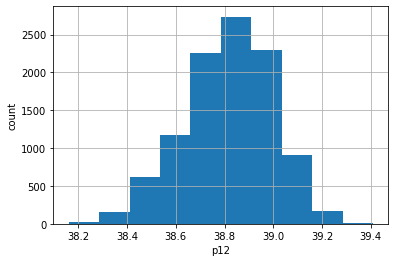

Детальное описание:
count    10328.000000
mean        38.813968
std          0.180779
min         38.160000
25%         38.700000
50%         38.830000
75%         38.940000
max         39.410000
Name: p12, dtype: float64
Столбец p12
Распределение признака:


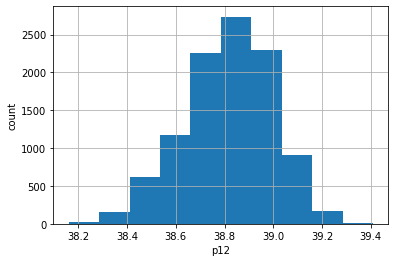

Детальное описание:
count    10328.000000
mean        38.813968
std          0.180779
min         38.160000
25%         38.700000
50%         38.830000
75%         38.940000
max         39.410000
Name: p12, dtype: float64
Столбец p13
Распределение признака:


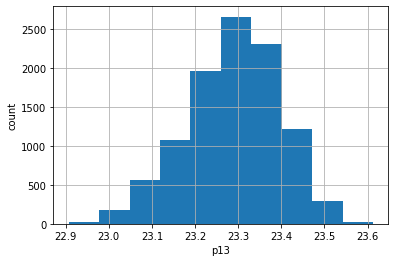

Детальное описание:
count    10328.000000
mean        23.288381
std          0.108073
min         22.907100
25%         23.220000
50%         23.296100
75%         23.364400
max         23.612700
Name: p13, dtype: float64
Столбец p14
Распределение признака:


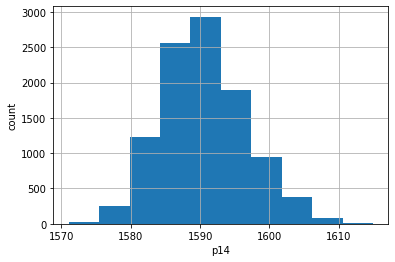

Детальное описание:
count    10328.000000
mean      1590.545079
std          6.132668
min       1571.040000
25%       1586.250000
50%       1590.160000
75%       1594.400000
max       1614.930000
Name: p14, dtype: float64
Столбец p15
Распределение признака:


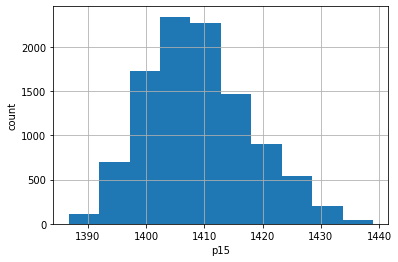

Детальное описание:
count    10328.000000
mean      1409.034477
std          8.949795
min       1386.690000
25%       1402.490000
50%       1408.240000
75%       1414.620000
max       1438.960000
Name: p15, dtype: float64
Столбец p16
Распределение признака:


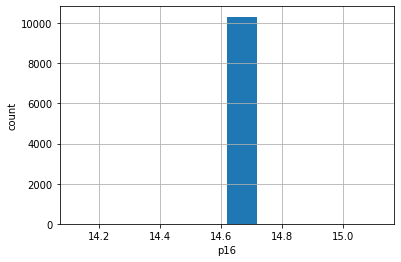

Детальное описание:
count    1.032800e+04
mean     1.462000e+01
std      2.138837e-12
min      1.462000e+01
25%      1.462000e+01
50%      1.462000e+01
75%      1.462000e+01
max      1.462000e+01
Name: p16, dtype: float64
Столбец p17
Распределение признака:


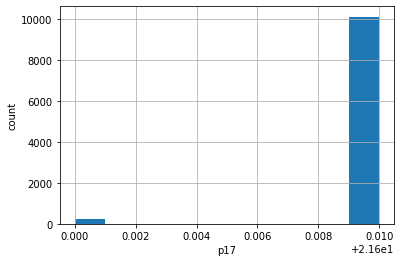

Детальное описание:
count    10328.000000
mean        21.609785
std          0.001450
min         21.600000
25%         21.610000
50%         21.610000
75%         21.610000
max         21.610000
Name: p17, dtype: float64
Столбец p18
Распределение признака:


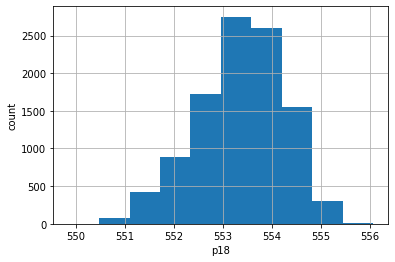

Детальное описание:
count    10328.000000
mean       553.361497
std          0.887098
min        549.850000
25%        552.800000
50%        553.430000
75%        554.010000
max        556.060000
Name: p18, dtype: float64
Столбец p19
Распределение признака:


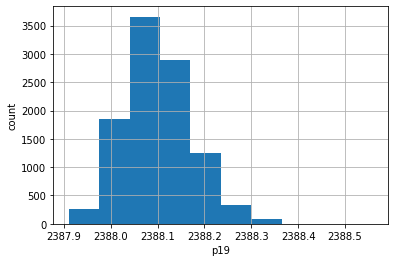

Детальное описание:
count    10328.000000
mean      2388.097597
std          0.071692
min       2387.910000
25%       2388.050000
50%       2388.100000
75%       2388.140000
max       2388.560000
Name: p19, dtype: float64
Столбец p20
Распределение признака:


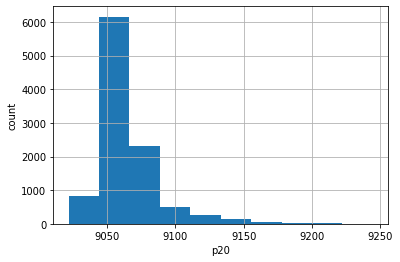

Детальное описание:
count    10328.000000
mean      9065.214648
std         22.555561
min       9021.730000
25%       9052.570000
50%       9060.655000
75%       9069.580000
max       9244.590000
Name: p20, dtype: float64
Столбец s1
Распределение признака:


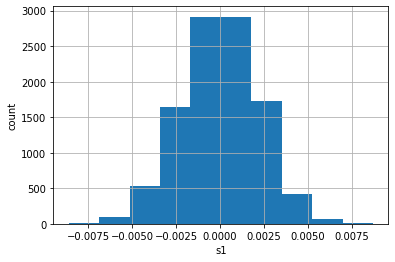

Детальное описание:
count    10328.000000
mean         0.000004
std          0.002183
min         -0.008600
25%         -0.001400
50%          0.000000
75%          0.001500
max          0.008700
Name: s1, dtype: float64
Столбец s2
Распределение признака:


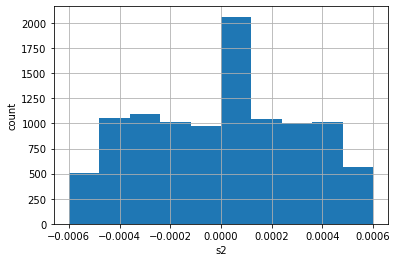

Детальное описание:
count    1.032800e+04
mean     1.742835e-07
std      2.945060e-04
min     -6.000000e-04
25%     -3.000000e-04
50%      0.000000e+00
75%      3.000000e-04
max      6.000000e-04
Name: s2, dtype: float64


In [34]:
desription('cycle')
desription('p00')
desription('p01')
desription('p02')
desription('p03')
desription('p04')
desription('p05')
desription('p06')
desription('p07')
desription('p08')
desription('p09')
desription('p10')
desription('p11')
desription('p12')
desription('p12')
desription('p13')
desription('p14')
desription('p15')
desription('p16')
desription('p17')
desription('p18')
desription('p19')
desription('p20')
desription('s1')
desription('s2')

# Feature engineering




Видим, что есть значение времени (равное счетчику циклов работы), но нет индикатора события поломки, добавим его

In [11]:
#Находим для каждого id максимальное значение cycle:
max_cycles = df_train.groupby('id').cycle.max()

In [12]:
#Создадим функцию, которой на вход подается строка датафрейма, и если значение cycle в этой строке равно значению соответствующего id в max_cycle, то возвращаем 1, иначе - 0.
def create_break(row):
    if row.cycle == max_cycles.loc[row.id]:
        return 1
    else:
        return 0

In [13]:
#Записываем результаты этой функции в новый столбец break
df_train['break'] = df_train.apply(lambda row: create_break(row), axis=1)

In [14]:
# проверяем, что получилось
df_train.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2,break
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004,0
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003,0
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003,0
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000,0
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002,0


In [15]:
df_train['break'].value_counts()

0    16058
1       80
Name: break, dtype: int64

In [16]:
#сохраним получившийся датасет в файл
df_train.to_csv('df.csv', index=False)

разделим обновленный датасет на обучающую, тестовую и валидационную выборки

In [18]:
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

Основываясь на полученной информации о данных, примем решение стандартизировать большинство из признаков

In [19]:
cols_standardize = ['p00', 'p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20']
cols_leave = ['p07', 's1', 's2']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [20]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

# Кодирование меток
Анализ выживания требует индивидуального преобразования меток.

Использовала LogisticHazard - это метод с дискретным временем. Num_durations определяет размер этой сетки дискретизации.

In [21]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['break'].values, df['cycle'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

durations_test, events_test = get_target(df_test)

In [22]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

Labtrans.cuts содержит сетку дискретизации. Будет использоваться для получения правильной шкалы времени для прогнозов выживаемости.

In [23]:
labtrans.cuts

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

Теперь y_train - это кортеж с индексами дискретизированного времени в дополнение к индикаторам событий.


In [24]:
y_train

(array([0, 0, 0, ..., 0, 0, 0]),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

In [25]:
labtrans.cuts[y_train[0]]

array([0., 0., 0., ..., 0., 0., 0.])

# Нейронная сеть
Для тестового задания будем использовать MLPVanilla из torchtuples. В качестве точки роста можно будет создать более продвинутые нейросети 

In [26]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

## Обучаем модель

In [27]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [28]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [29]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.4404,	val_loss: 0.1413
1:	[0s / 0s],		train_loss: 0.0639,	val_loss: 0.0177
2:	[0s / 0s],		train_loss: 0.0279,	val_loss: 0.0158
3:	[0s / 0s],		train_loss: 0.0258,	val_loss: 0.0111
4:	[0s / 0s],		train_loss: 0.0222,	val_loss: 0.0104
5:	[0s / 0s],		train_loss: 0.0233,	val_loss: 0.0159
6:	[0s / 0s],		train_loss: 0.0216,	val_loss: 0.0108
7:	[0s / 1s],		train_loss: 0.0188,	val_loss: 0.0103
8:	[0s / 1s],		train_loss: 0.0204,	val_loss: 0.0101
9:	[0s / 1s],		train_loss: 0.0204,	val_loss: 0.0127
10:	[0s / 1s],		train_loss: 0.0195,	val_loss: 0.0127
11:	[0s / 1s],		train_loss: 0.0194,	val_loss: 0.0100
12:	[0s / 1s],		train_loss: 0.0203,	val_loss: 0.0101
13:	[0s / 1s],		train_loss: 0.0228,	val_loss: 0.0115
14:	[0s / 1s],		train_loss: 0.0172,	val_loss: 0.0102
15:	[0s / 1s],		train_loss: 0.0155,	val_loss: 0.0119
16:	[0s / 2s],		train_loss: 0.0172,	val_loss: 0.0113
17:	[0s / 2s],		train_loss: 0.0154,	val_loss: 0.0106
18:	[0s / 2s],		train_loss: 0.0153,	val_loss: 0.0104
19:

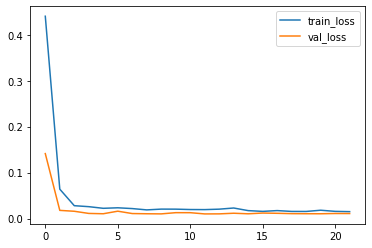

In [30]:
_ = log.plot()

После завершения колбек EarlyStopping загружает наиболее эффективную модель (с точки зрения ошибки). 

In [31]:
log.to_pandas().val_loss.min()

0.009986515156924725

In [32]:
model.score_in_batches(val)

{'loss': 0.009986515156924725}


## Предсказываем
Сначала предскажем выживаемость для тестовой выборки

In [33]:
surv = model.predict_surv_df(x_test)

Выведем на график оценки выживаемости для первых 5 наблюдений

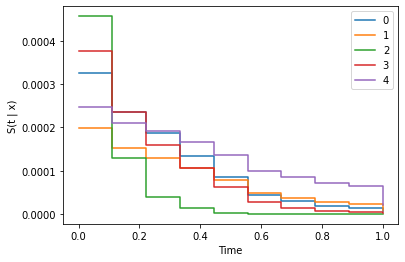

In [34]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

Проинтерполируем оценки выживаемости. Заменим по 10 точек каждой точкой сетки.

In [35]:
surv = model.interpolate(10).predict_surv_df(x_test)

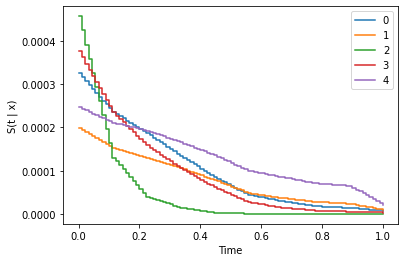

In [36]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Оценка
Класс EvalSurv содержит некоторые полезные критерии оценки для прогнозирования времени до события. Мы устанавливаем censor_surv = 'km', то есть будем использовать методология Каплана-Мейера для описания функции выживания. Этот метод позволяет сравнивать функции выживания между собой, чтобы определить есть ли между ними статистически-значимая разница

In [37]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#Сoncordance index
Полученная модель демонстрирует следующие значения concordance index (индекс соответствия), который используется для измерения того, насколько хорошо модель предсказывает время до события.

In [38]:
ev.concordance_td('antolini')

0.9885365853658536

В целом, результат достаточно хороший. 